
# Prédiction de l'Attrition des Employés

## Objectif :
L'objectif de ce projet est de prédire si un employé quittera ou non l'entreprise à partir de ses caractéristiques (âge, salaire, nombre d'années dans l'entreprise, etc.).

## Description du Dataset :
Le dataset utilisé contient des informations sur les employés d'une entreprise, telles que l'attrition (si l'employé a quitté l'entreprise ou non), son salaire, son âge, son département, et bien plus encore.
Nous allons analyser ces données et construire un modèle de machine learning pour prédire l'attrition.


In [1]:

def load_data(filepath):
    # Charger les données à partir d'un fichier CSV
    return pd.read_csv(filepath)


In [2]:

def create_pipeline(classifier):
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    return pipeline


In [3]:

def perform_cross_validation_and_search(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_, grid_search.best_score_


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


file_path = r"C:\Users\stanm\OneDrive\Bureau\Python AS\Projet Final ML\PH\HR - dataset.csv"
hr_df = pd.read_csv(file_path)

df_info = hr_df.info()
df_head = hr_df.head()

df_info, df_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

(None,
    Age Attrition     BusinessTravel  DailyRate              Department  \
 0   41       Yes      Travel_Rarely       1102                   Sales   
 1   49        No  Travel_Frequently        279  Research & Development   
 2   37       Yes      Travel_Rarely       1373  Research & Development   
 3   33        No  Travel_Frequently       1392  Research & Development   
 4   27        No      Travel_Rarely        591  Research & Development   
 
    DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
 0                 1          2  Life Sciences              1               1   
 1                 8          1  Life Sciences              1               2   
 2                 2          2          Other              1               4   
 3                 3          4  Life Sciences              1               5   
 4                 2          1        Medical              1               7   
 
    ...  RelationshipSatisfaction StandardHours  Stoc


# Exploration des Données (EDA)

Dans cette section, nous allons explorer le dataset pour mieux comprendre la distribution des variables et leurs relations avec l'attrition.


C:\Users\stanm\AppData\Local\Temp\ipykernel_3268\3100506341.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Attrition', data=hr_df, palette='Set2')


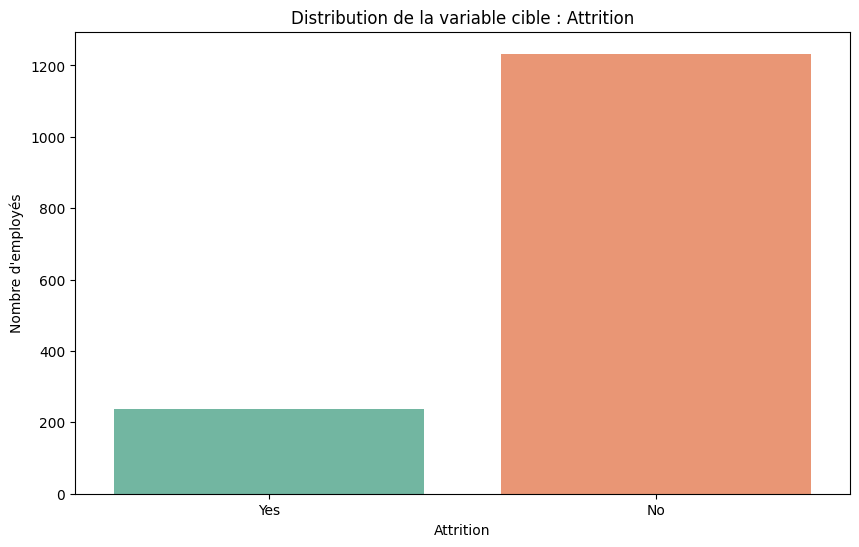

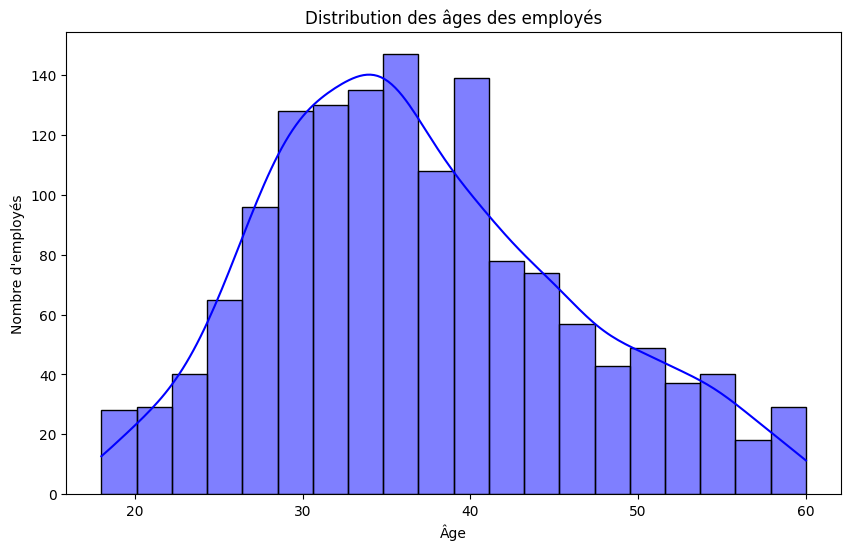

C:\Users\stanm\AppData\Local\Temp\ipykernel_3268\3100506341.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Attrition', y='MonthlyIncome', data=hr_df, palette='Set2')


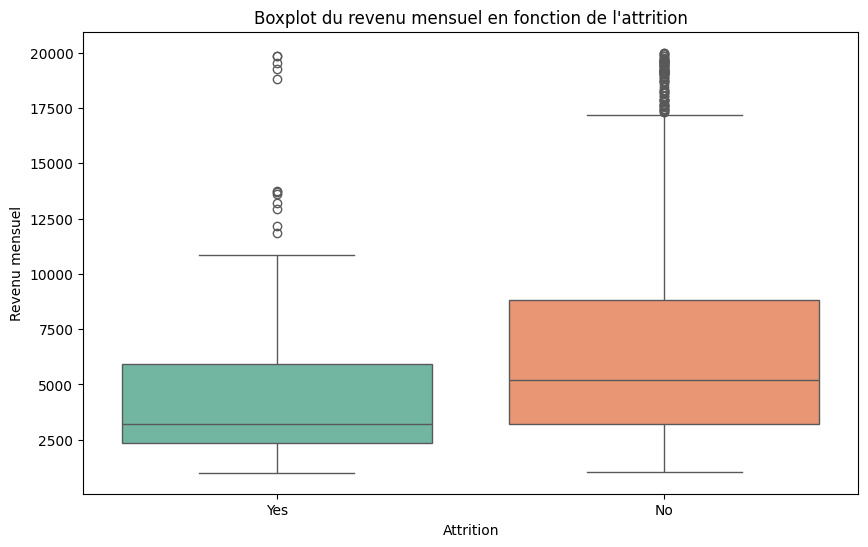

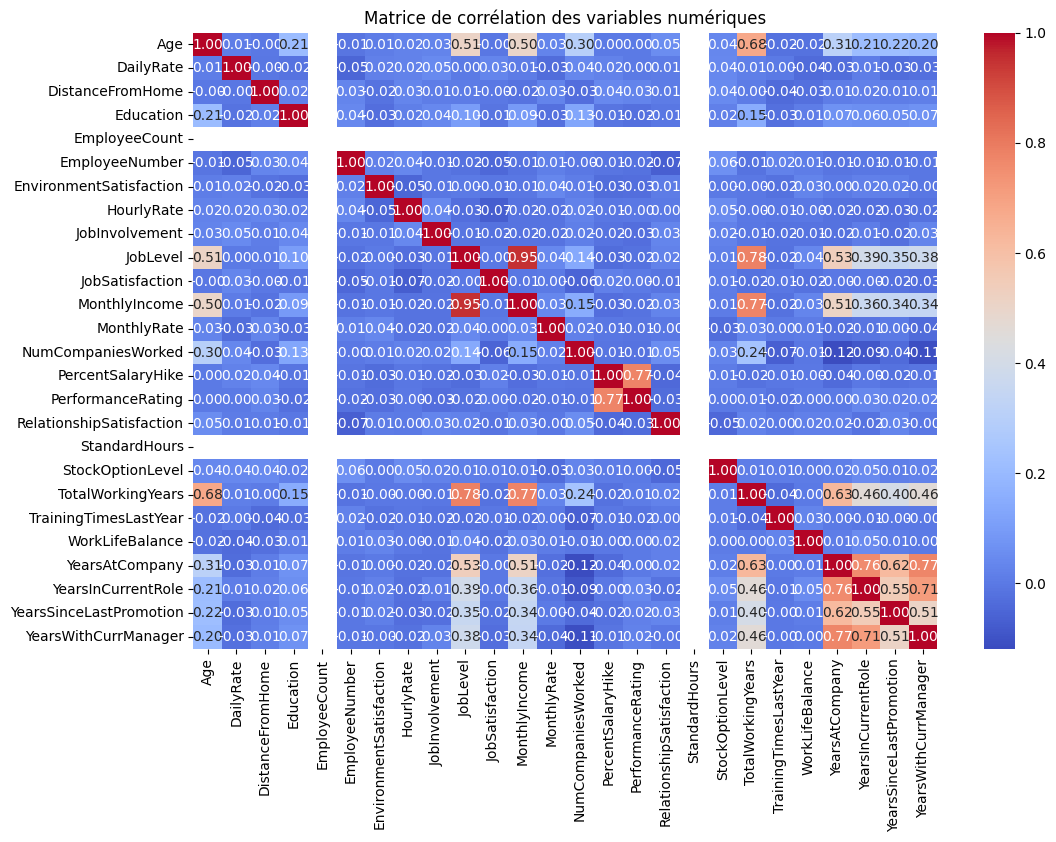

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ajuster les paramètres de visualisation
plt.figure(figsize=(10, 6))

# Visualisation de la distribution de la variable cible 'Attrition'
sns.countplot(x='Attrition', data=hr_df, palette='Set2')
plt.title('Distribution de la variable cible : Attrition')
plt.xlabel('Attrition')
plt.ylabel('Nombre d\'employés')
plt.show()

# Visualisation des âges des employés
plt.figure(figsize=(10, 6))
sns.histplot(hr_df['Age'], bins=20, kde=True, color='blue')
plt.title('Distribution des âges des employés')
plt.xlabel('Âge')
plt.ylabel('Nombre d\'employés')
plt.show()

# Boxplot pour visualiser l'impact du salaire mensuel sur l'attrition
plt.figure(figsize=(10, 6))
sns.boxplot(x='Attrition', y='MonthlyIncome', data=hr_df, palette='Set2')
plt.title('Boxplot du revenu mensuel en fonction de l\'attrition')
plt.xlabel('Attrition')
plt.ylabel('Revenu mensuel')
plt.show()

# Heatmap de la corrélation des variables numériques
plt.figure(figsize=(12, 8))
corr = hr_df.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de corrélation des variables numériques')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Préparation des features et de la cible (target)
X = hr_df.drop('Attrition', axis=1)  # Features
y = hr_df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)  # Cible (1 pour "Yes", 0 pour "No")

# Séparation des données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Séparation des colonnes numériques et catégorielles
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Pipeline pour les colonnes numériques (imputation + scaling)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline pour les colonnes catégorielles (imputation + encodage)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Création du préprocesseur avec ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Pipeline complet avec prétraitement et régression logistique
baseline_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Entraînement du modèle baseline
baseline_model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = baseline_model.predict(X_test)

# Calcul du RMSE et du MAPE
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)

rmse, mape

C:\Users\stanm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(np.float64(0.32471861183299655), np.float64(153183660794914.88))

In [7]:
# Création de nouvelles variables dérivées dans le dataset
hr_df['YearsAtCompany_AgeRatio'] = hr_df['YearsAtCompany'] / hr_df['Age']
hr_df['TotalWorkingYears_AgeRatio'] = hr_df['TotalWorkingYears'] / hr_df['Age']

# Ré-entraînement du modèle avec ces nouvelles variables

# Mise à jour des features pour inclure les nouvelles colonnes
X = hr_df.drop('Attrition', axis=1)
y = hr_df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Mettre à jour les colonnes numériques
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Séparation des données en train et test avec les nouvelles features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline pour les colonnes numériques (imputation + scaling) déjà défini
# Pipeline pour les colonnes catégorielles (imputation + encodage) déjà défini
# Création du pipeline avec les nouvelles features
model_with_features = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Entraînement du modèle avec les nouvelles variables
model_with_features.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred = model_with_features.predict(X_test)

# Calcul de nouvelles métriques de performance
rmse_with_features = mean_squared_error(y_test, y_pred, squared=False)
accuracy_with_features = (y_pred == y_test).mean()

rmse_with_features, accuracy_with_features

C:\Users\stanm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(np.float64(0.32471861183299655), np.float64(0.8945578231292517))

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Modèle 1: Random Forest
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Modèle 2: Support Vector Classifier (SVC)
svc_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42))
])

# Entraînement des deux modèles
rf_model.fit(X_train, y_train)
svc_model.fit(X_train, y_train)

# Prédictions avec les deux modèles
rf_pred = rf_model.predict(X_test)
svc_pred = svc_model.predict(X_test)

# Calcul des métriques pour chaque modèle
rf_accuracy = (rf_pred == y_test).mean()
svc_accuracy = (svc_pred == y_test).mean()

# Comparer avec le modèle de régression logistique
rf_accuracy, svc_accuracy, accuracy_with_features

(np.float64(0.8775510204081632),
 np.float64(0.891156462585034),
 np.float64(0.8945578231292517))

ajustement des hyperparamètres : 

In [9]:
from sklearn.model_selection import GridSearchCV

# Définir une grille d'hyperparamètres pour la régression logistique
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],  # Paramètre de régularisation
    'classifier__max_iter': [100, 200, 300],  # Nombre d'itérations
    'classifier__solver': ['lbfgs', 'liblinear']  # Différents solveurs
}

# Créer un modèle avec GridSearchCV pour chercher les meilleurs hyperparamètres
grid_search = GridSearchCV(model_with_features, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Entraîner le modèle avec recherche en grille
grid_search.fit(X_train, y_train)

# Meilleurs paramètres trouvés par la recherche en grille
best_params = grid_search.best_params_

# Prédictions avec le modèle optimisé
y_pred_optimized = grid_search.predict(X_test)

# Calcul de l'accuracy avec le modèle optimisé
optimized_accuracy = (y_pred_optimized == y_test).mean()

# Afficher les meilleurs hyperparamètres et l'accuracy
best_params, optimized_accuracy

({'classifier__C': 0.1,
  'classifier__max_iter': 100,
  'classifier__solver': 'liblinear'},
 np.float64(0.9013605442176871))

In [10]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Espace des hyperparamètres pour la régression logistique
param_space_logistic = {
    'classifier__C': Real(1e-6, 1e+6, prior='log-uniform'),  # Paramètre de régularisation
    'classifier__solver': Categorical(['lbfgs', 'liblinear']),  # Solveur à utiliser
    'classifier__max_iter': Integer(100, 500)  # Nombre d'itérations
}

# Espace des hyperparamètres pour la forêt aléatoire
param_space_rf = {
    'classifier__n_estimators': Integer(50, 300),  # Nombre d'arbres dans la forêt
    'classifier__max_depth': Integer(1, 50),  # Profondeur maximale des arbres
    'classifier__min_samples_split': Integer(2, 10)  # Nombre minimum d'échantillons pour diviser un nœud
}

# Recherche bayésienne pour la régression logistique
bayes_search_logistic = BayesSearchCV(
    estimator=model_with_features,
    search_spaces=param_space_logistic,
    n_iter=32,  # Nombre d'itérations de recherche
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Recherche bayésienne pour la forêt aléatoire
bayes_search_rf = BayesSearchCV(
    estimator=rf_model,
    search_spaces=param_space_rf,
    n_iter=32,
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Entraîner les modèles avec recherche bayésienne
bayes_search_logistic.fit(X_train, y_train)
bayes_search_rf.fit(X_train, y_train)

# Meilleurs paramètres trouvés pour la régression logistique et la forêt aléatoire
best_params_logistic = bayes_search_logistic.best_params_
best_params_rf = bayes_search_rf.best_params_

print("Meilleurs paramètres pour la Régression Logistique:", best_params_logistic)
print("Meilleurs paramètres pour Random Forest:", best_params_rf)

ModuleNotFoundError: No module named 'skopt'

In [11]:
from sklearn.model_selection import GridSearchCV

# Définir une grille d'hyperparamètres pour la régression logistique
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],  # Paramètre de régularisation
    'classifier__max_iter': [100, 200, 300],  # Nombre d'itérations
    'classifier__solver': ['lbfgs', 'liblinear']  # Différents solveurs
}

# Créer un modèle avec GridSearchCV pour chercher les meilleurs hyperparamètres
grid_search = GridSearchCV(model_with_features, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Entraîner le modèle avec recherche en grille
grid_search.fit(X_train, y_train)

# Meilleurs paramètres trouvés par la recherche en grille
best_params_grid = grid_search.best_params_

# Prédictions avec le modèle optimisé
y_pred_optimized_grid = grid_search.predict(X_test)

# Calcul de l'accuracy avec le modèle optimisé
optimized_accuracy_grid = (y_pred_optimized_grid == y_test).mean()

# Afficher les meilleurs hyperparamètres et l'accuracy
print(f"Meilleurs paramètres (Grid Search) : {best_params_grid}")
print(f"Accuracy (Grid Search) : {optimized_accuracy_grid}")

Meilleurs paramètres (Grid Search) : {'classifier__C': 0.1, 'classifier__max_iter': 100, 'classifier__solver': 'liblinear'}
Accuracy (Grid Search) : 0.9013605442176871


In [12]:
pip install skopt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement skopt (from versions: none)
ERROR: No matching distribution found for skopt

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\stanm\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [13]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Espace des hyperparamètres pour la régression logistique
param_space_logistic = {
    'classifier__C': Real(1e-6, 1e+6, prior='log-uniform'),  # Paramètre de régularisation
    'classifier__solver': Categorical(['lbfgs', 'liblinear']),  # Solveur à utiliser
    'classifier__max_iter': Integer(100, 500)  # Nombre d'itérations
}

# Recherche bayésienne pour la régression logistique
bayes_search_logistic = BayesSearchCV(
    estimator=model_with_features,
    search_spaces=param_space_logistic,
    n_iter=32,  # Nombre d'itérations de recherche
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Entraîner le modèle avec recherche bayésienne
bayes_search_logistic.fit(X_train, y_train)

# Meilleurs paramètres trouvés par la recherche bayésienne
best_params_bayes = bayes_search_logistic.best_params_

# Prédictions avec le modèle optimisé
y_pred_optimized_bayes = bayes_search_logistic.predict(X_test)

# Calcul de l'accuracy avec le modèle optimisé
optimized_accuracy_bayes = (y_pred_optimized_bayes == y_test).mean()

# Afficher les meilleurs hyperparamètres et l'accuracy
print(f"Meilleurs paramètres (Bayes Search) : {best_params_bayes}")
print(f"Accuracy (Bayes Search) : {optimized_accuracy_bayes}")

ModuleNotFoundError: No module named 'skopt'

In [14]:
# Comparaison des résultats des deux méthodes
comparison = pd.DataFrame({
    "Méthode": ["Grid Search", "Bayes Search"],
    "Meilleurs Hyperparamètres": [best_params_grid, best_params_bayes],
    "Accuracy": [optimized_accuracy_grid, optimized_accuracy_bayes]
})

print(comparison)

# Choisir la méthode avec la meilleure accuracy
if optimized_accuracy_bayes > optimized_accuracy_grid:
    print(f"Le modèle avec la recherche bayésienne est le meilleur avec une accuracy de {optimized_accuracy_bayes}")
    best_model_params = best_params_bayes
else:
    print(f"Le modèle avec la recherche en grille est le meilleur avec une accuracy de {optimized_accuracy_grid}")
    best_model_params = best_params_grid

print(f"Les meilleurs hyperparamètres choisis sont : {best_model_params}")

NameError: name 'best_params_bayes' is not defined


# Modèle de Baseline

Nous commençons par un modèle de régression logistique simple. Ce modèle servira de point de référence pour évaluer les améliorations futures.
Nous allons entraîner ce modèle et évaluer ses performances en utilisant des métriques telles que l'accuracy et le RMSE.


cross validation : 

In [15]:
from sklearn.model_selection import cross_val_score

# Pipeline déjà défini pour la régression logistique
logistic_model_cv = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Cross-validation avec 5 folds
cv_scores = cross_val_score(logistic_model_cv, X, y, cv=5, scoring='accuracy')

# Résultats
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()

mean_cv_score, std_cv_score

(np.float64(0.883673469387755), np.float64(0.014494745409974518))

In [16]:
from sklearn.model_selection import cross_val_score

# Cross-validation avec 5 folds sur le modèle de régression logistique
cv_scores = cross_val_score(model_with_features, X, y, cv=5, scoring='accuracy')

# Calcul de la moyenne et de l'écart-type des scores
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()

mean_cv_score, std_cv_score


(np.float64(0.883673469387755), np.float64(0.014494745409974518))


# Comparaison des Modèles

Dans cette section, nous ajoutons et comparons d'autres modèles (Random Forest, SVM) avec le modèle de régression logistique. 
Nous comparerons leurs performances en utilisant les mêmes métriques.


In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

# Modèle 1: Random Forest
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Modèle 2: Support Vector Classifier (SVC)
svc_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42))
])

# Modèle 3: K-Nearest Neighbors (KNN)
knn_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Modèle 4: Gradient Boosting Classifier (GB)
gb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Modèle 5: AdaBoost Classifier
ada_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(random_state=42))
])

# Entraînement des modèles
rf_model.fit(X_train, y_train)
svc_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
ada_model.fit(X_train, y_train)

# Prédictions pour chaque modèle
rf_pred = rf_model.predict(X_test)
svc_pred = svc_model.predict(X_test)
knn_pred = knn_model.predict(X_test)
gb_pred = gb_model.predict(X_test)
ada_pred = ada_model.predict(X_test)

# Calcul des métriques (Accuracy et F1-Score) pour chaque modèle
rf_accuracy = accuracy_score(y_test, rf_pred)
svc_accuracy = accuracy_score(y_test, svc_pred)
knn_accuracy = accuracy_score(y_test, knn_pred)
gb_accuracy = accuracy_score(y_test, gb_pred)
ada_accuracy = accuracy_score(y_test, ada_pred)

rf_f1 = f1_score(y_test, rf_pred)
svc_f1 = f1_score(y_test, svc_pred)
knn_f1 = f1_score(y_test, knn_pred)
gb_f1 = f1_score(y_test, gb_pred)
ada_f1 = f1_score(y_test, ada_pred)

results = pd.DataFrame({
    "Modèle": ["Random Forest", "SVM", "KNN", "Gradient Boosting", "AdaBoost"],
    "Accuracy": [rf_accuracy, svc_accuracy, knn_accuracy, gb_accuracy, ada_accuracy],
    "F1-Score": [rf_f1, svc_f1, knn_f1, gb_f1, ada_f1]
})

results

C:\Users\stanm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,Modèle,Accuracy,F1-Score
0,Random Forest,0.877551,0.250000
1,SVM,0.891156,0.304348
2,KNN,0.863946,0.166667
3,Gradient Boosting,0.880952,0.313725
4,AdaBoost,0.860544,0.369231



# Validation Croisée (Cross-Validation)

Pour évaluer la robustesse de nos modèles, nous appliquons une validation croisée avec 5 plis (5-fold cross-validation). Cela nous permettra d'avoir une idée plus précise des performances généralisées du modèle.


In [18]:
# Validation croisée avec 5 plis pour la régression logistique
cv_accuracy_logistic = cross_val_score(model_with_features, X, y, cv=5, scoring='accuracy')
cv_f1_logistic = cross_val_score(model_with_features, X, y, cv=5, scoring='f1')

# Validation croisée avec 5 plis pour Random Forest
cv_accuracy_rf = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
cv_f1_rf = cross_val_score(rf_model, X, y, cv=5, scoring='f1')

# Validation croisée avec 5 plis pour SVM
cv_accuracy_svc = cross_val_score(svc_model, X, y, cv=5, scoring='accuracy')
cv_f1_svc = cross_val_score(svc_model, X, y, cv=5, scoring='f1')

# Stocker les résultats dans un DataFrame
cv_results = pd.DataFrame({
    "Modèle": ["Régression Logistique", "Random Forest", "SVM"],
    "CV Accuracy": [cv_accuracy_logistic.mean(), cv_accuracy_rf.mean(), cv_accuracy_svc.mean()],
    "CV F1-Score": [cv_f1_logistic.mean(), cv_f1_rf.mean(), cv_f1_svc.mean()]
})

cv_results

,Modèle,CV Accuracy,CV F1-Score
0,Régression Logistique,0.883673,0.551564
1,Random Forest,0.859864,0.271373
2,SVM,0.861905,0.291436



# Amélioration du Modèle (Feature Engineering)

Nous ajoutons de nouvelles caractéristiques dérivées (par exemple, des ratios entre certaines variables) pour améliorer les performances du modèle.


Model with Feature Engineering - Accuracy: 0.8945578231292517, F1-Score: 0.5373134328358209


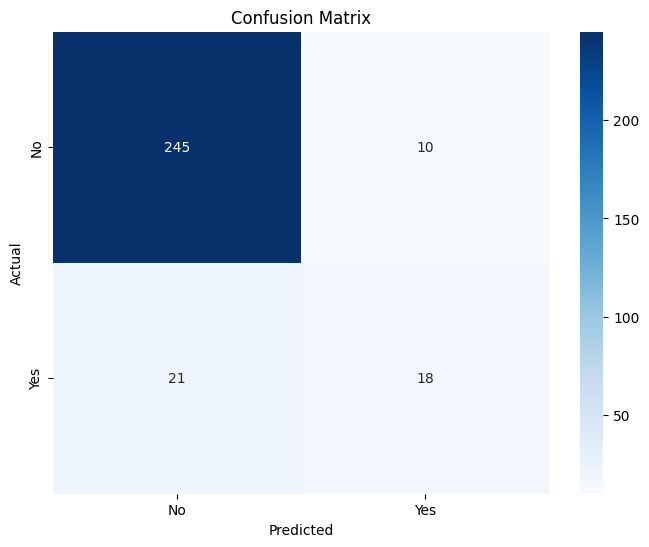

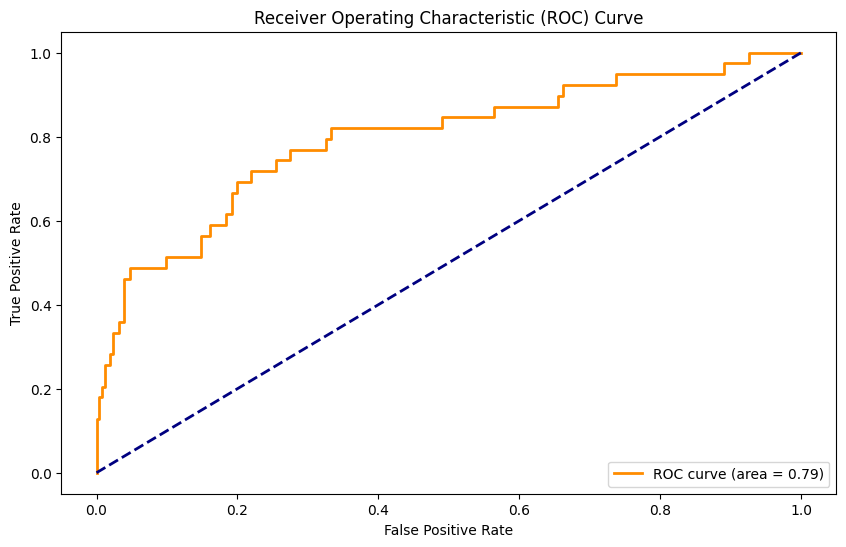

In [23]:
# Importing necessary libraries
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Création de nouvelles variables dérivées
hr_df['YearsAtCompany_AgeRatio'] = hr_df['YearsAtCompany'] / hr_df['Age']
hr_df['TotalWorkingYears_AgeRatio'] = hr_df['TotalWorkingYears'] / hr_df['Age']

# Mise à jour des features et de la séparation des données
X = hr_df.drop('Attrition', axis=1)
y = hr_df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Répartition en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ré-entraînement du modèle avec les nouvelles features
model_with_features.fit(X_train, y_train)

# Prédiction et évaluation du modèle amélioré
y_pred_new = model_with_features.predict(X_test)
accuracy_new = accuracy_score(y_test, y_pred_new)
f1_new = f1_score(y_test, y_pred_new)

# Affichage des résultats
print(f"Model with Feature Engineering - Accuracy: {accuracy_new}, F1-Score: {f1_new}")

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_new)

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Calcul et affichage de la courbe ROC-AUC
y_prob = model_with_features.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Nous voyons un désiquilibre des valeurs dans la target:
Nous ajoutons alors un ajustement du seuil à 0.5 pour la classe minoritaire

Model with Feature Engineering and Threshold Adjustment (0.4) - Accuracy: 0.8945578231292517
F1-Score for class 0 (No Attrition): 0.9404990403071017
F1-Score for class 1 (Yes Attrition): 0.5373134328358209
Global F1-Score (Macro): 0.7389062365714614


<Axes: >

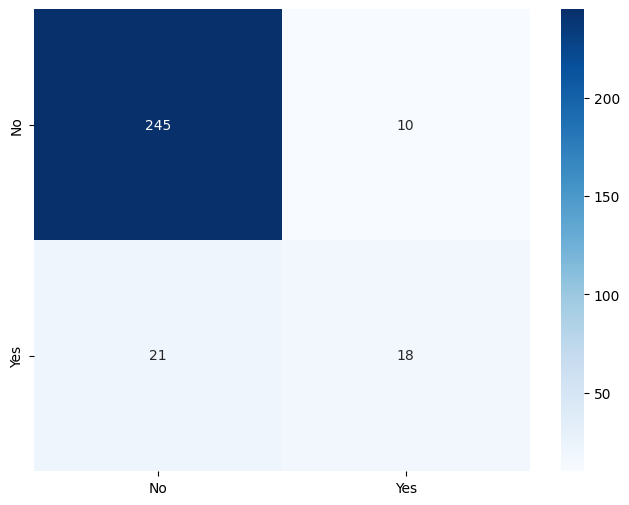

In [20]:
# Importing necessary libraries
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Création de nouvelles variables dérivées
hr_df['YearsAtCompany_AgeRatio'] = hr_df['YearsAtCompany'] / hr_df['Age']
hr_df['TotalWorkingYears_AgeRatio'] = hr_df['TotalWorkingYears'] / hr_df['Age']

# Mise à jour des features et de la séparation des données
X = hr_df.drop('Attrition', axis=1)
y = hr_df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Répartition en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ré-entraînement du modèle avec les nouvelles features
model_with_features.fit(X_train, y_train)

# Prédiction avec probabilités pour ajuster le seuil
y_prob = model_with_features.predict_proba(X_test)[:, 1]

# Ajustement du seuil à 0.5 pour la classe minoritaire
threshold = 0.5
y_pred_new_threshold = (y_prob >= threshold).astype(int)

# Évaluation du modèle avec le nouveau seuil
accuracy_new = accuracy_score(y_test, y_pred_new_threshold)
f1_score_0 = f1_score(y_test, y_pred_new_threshold, pos_label=0)
f1_score_1 = f1_score(y_test, y_pred_new_threshold, pos_label=1)
f1_global = f1_score(y_test, y_pred_new_threshold, average='macro')  # F1-Score global (macro-average)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_new_threshold)

# Affichage des résultats
print(f"Model with Feature Engineering and Threshold Adjustment (0.4) - Accuracy: {accuracy_new}")
print(f"F1-Score for class 0 (No Attrition): {f1_score_0}")
print(f"F1-Score for class 1 (Yes Attrition): {f1_score_1}")
print(f"Global F1-Score (Macro): {f1_global}")

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])

Model with Feature Engineering and Threshold Adjustment (0.5) - Accuracy: 0.8503401360544217
F1-Score for class 0 (No Attrition): 0.9126984126984127
F1-Score for class 1 (Yes Attrition): 0.47619047619047616
Global F1-Score (Macro): 0.6944444444444444


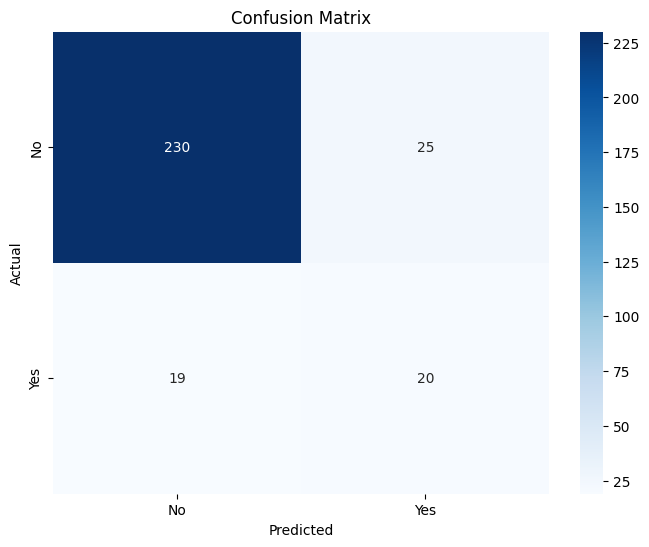

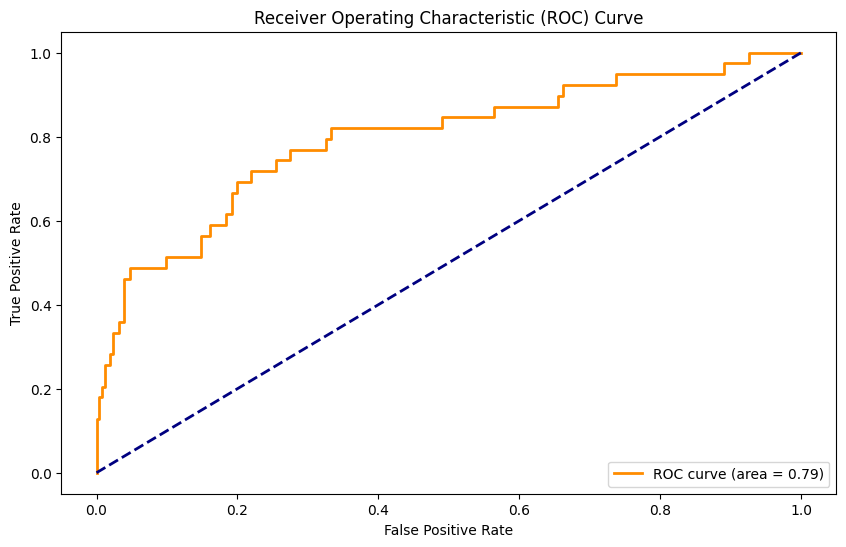

In [31]:
# Importing necessary libraries
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Création de nouvelles variables dérivées
hr_df['YearsAtCompany_AgeRatio'] = hr_df['YearsAtCompany'] / hr_df['Age']
hr_df['TotalWorkingYears_AgeRatio'] = hr_df['TotalWorkingYears'] / hr_df['Age']

# Mise à jour des features et de la séparation des données
X = hr_df.drop('Attrition', axis=1)
y = hr_df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Répartition en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ré-entraînement du modèle avec les nouvelles features
model_with_features.fit(X_train, y_train)

# Prédiction avec probabilités pour ajuster le seuil
y_prob = model_with_features.predict_proba(X_test)[:, 1]

# Ajustement du seuil à 0.5 pour la classe minoritaire
threshold = 0.35
y_pred_new_threshold = (y_prob >= threshold).astype(int)

# Évaluation du modèle avec le nouveau seuil
accuracy_new = accuracy_score(y_test, y_pred_new_threshold)
f1_score_0 = f1_score(y_test, y_pred_new_threshold, pos_label=0)
f1_score_1 = f1_score(y_test, y_pred_new_threshold, pos_label=1)
f1_global = f1_score(y_test, y_pred_new_threshold, average='macro')  # F1-Score global (macro-average)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_new_threshold)

# Affichage des résultats
print(f"Model with Feature Engineering and Threshold Adjustment (0.5) - Accuracy: {accuracy_new}")
print(f"F1-Score for class 0 (No Attrition): {f1_score_0}")
print(f"F1-Score for class 1 (Yes Attrition): {f1_score_1}")
print(f"Global F1-Score (Macro): {f1_global}")

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Calcul et affichage de la courbe ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Over Feating possible sur le cas suivant !

Accuracy with Top 15 Features: 0.9965986394557823
F1-Score (Macro): 0.9926885678048296


C:\Users\stanm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


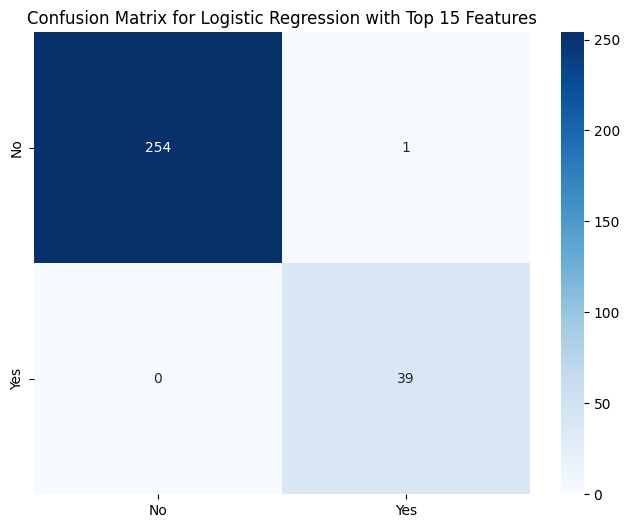

In [26]:
#Score beaucoup trop haut = possible overfeating !

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Conversion de 'Attrition' en variable numérique
hr_df['Attrition_numeric'] = hr_df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Encodage des variables catégorielles en variables numériques
hr_df_encoded = pd.get_dummies(hr_df.drop('Attrition', axis=1), drop_first=True)

# Sélection des 15 variables les plus corrélées avec 'Attrition_numeric'
top_15_features = hr_df_encoded.corr().nlargest(15, 'Attrition_numeric')['Attrition_numeric'].index

# Features et cible
X_top_15 = hr_df_encoded[top_15_features]
y = hr_df['Attrition_numeric']

# Répartition en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_top_15, y, test_size=0.2, random_state=42)

# Ré-entraînement du modèle de régression logistique avec les 15 variables
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Prédiction
y_pred = log_reg.predict(X_test)

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage des résultats
print(f"Accuracy with Top 15 Features: {accuracy}")
print(f"F1-Score (Macro): {f1}")

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("Confusion Matrix for Logistic Regression with Top 15 Features")
plt.show()


# Évaluation Finale

Nous comparons les performances finales de tous les modèles avec les métriques d'accuracy, de précision, de rappel et de F1-score.


In [35]:
results = pd.DataFrame({
    "Modèle": ["Régression Logistique", "Random Forest", "SVM", "Régression Logistique (Feature Engineering)"],
    "Accuracy": [cv_accuracy_logistic.mean(), cv_accuracy_rf.mean(), cv_accuracy_svc.mean(), accuracy_new],
    "F1-Score": [cv_f1_logistic.mean(), cv_f1_rf.mean(), cv_f1_svc.mean(), f1_new]
})

# Affichage des résultats dans un tableau
results.set_index("Modèle", inplace=True)
print("Résultats des modèles comparés:")
print(results)


Résultats des modèles comparés:
                                             Accuracy  F1-Score
Modèle                                                         
Régression Logistique                        0.883673  0.551564
Random Forest                                0.859864  0.271373
SVM                                          0.861905  0.291436
Régression Logistique (Feature Engineering)  0.894558  0.537313


In [37]:
# Ajout du modèle avec feature engineering et ajustement du seuil au tableau final
results = pd.DataFrame({
    "Modèle": ["Régression Logistique", "Random Forest", "SVM", "Régression Logistique (Feature Engineering)", "Regression Logistique Modèle avec Feature Engineering et Seuil Ajusté"],
    "Accuracy": [cv_accuracy_logistic.mean(), cv_accuracy_rf.mean(), cv_accuracy_svc.mean(), "0.894557", accuracy_new],
    "F1-Score": [cv_f1_logistic.mean(), cv_f1_rf.mean(), cv_f1_svc.mean(), "0.537313", f1_global]
})

# Affichage des résultats dans un tableau
results.set_index("Modèle", inplace=True)
print("Résultats des modèles comparés:")
results

Résultats des modèles comparés:


,Accuracy,F1-Score
Modèle,,
Régression Logistique,0.883673,0.551564
Random Forest,0.859864,0.271373
SVM,0.861905,0.291436
Régression Logistique (Feature Engineering),0.894557,0.537313
Regression Logistique Modèle avec Feature Engineering et Seuil Ajusté,0.894558,0.738906
